<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/CNN_Model/3Channel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This document contains modified code from https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/. 

In [ ]:
# Import statements
import pandas as pd
from nltk import word_tokenize
from numpy import array
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [ ]:
# Loading in preproccessed data
PATH = "/content/drive/My Drive/Data/"
data = pd.read_csv(PATH + "final_preproccessed_data.csv", lineterminator='\n')

data

,title,text,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,1
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,1
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,1
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,1
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1
...,...,...,...
29484,Travel deals: Get $1200 of air credit for two ...,APT is offering savings on its new Cape York a...,0
29485,Hospital patients 'more likely to die if admit...,Patients admitted to NHS hospitals on weekends...,0
29486,A Taiwanese Recycler's Belief That All Waste I...,"TAIPEI, Taiwan , Sept. 8, 2015 /PRNewswire/ --...",0
29487,Season curtain raiser is ideal way to honour John,Blackburn Sunday League John Haydock Memorial ...,0


In [ ]:
# Performing test-train split
data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
# Tokenizing data
def tokenize_text(text):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(text)
	return tokenizer

tokenizer = tokenize_text(data_train['text'])

In [ ]:
# Find max document length
maxlen = max([len(s.split()) for s in data_train['text']]) 

print('Max document length: %d' % maxlen)

Max document length: 3194


In [ ]:
# Find vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 199617


In [ ]:
# Encode lines
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  # Pad the encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

encoded_data = encode_text(tokenizer, data_train['text'], maxlen)
encoded_data_testing = encode_text(tokenizer, data_test['text'], maxlen)

In [ ]:
def define_model(length, vocab_size):
	# Channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# Channel 2
	embedding2 = Embedding(vocab_size, 100)(inputs1)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# Channel 3
	embedding3 = Embedding(vocab_size, 100)(inputs1)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# Merge Channels
	merged = concatenate([flat1, flat2, flat3])
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1], outputs=outputs)
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Print model summary
	print(model.summary())
  # Save model plot
	plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/multichannel.png')
	return model


In [ ]:
# Define model
model = define_model(maxlen, vocab_size)
# Fit model to data
history = model.fit([encoded_data], array(data_train['label']), epochs=25, batch_size=32, validation_data=(encoded_data_testing, array(data_test['label'])))
# Save model
model.save('model.h5')

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3194)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 3194, 100)    19961700    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 3194, 100)    19961700    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 3194, 100)    19961700    input_3[0][0]                    
_______________________________________________________________________________________

In [ ]:
# Using code modified from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

pred = model.predict(encoded_data_testing)
pred = np.rint(pred)

# Evaluate model on training data
loss_train, acc_train = model.evaluate([encoded_data], array(data_train['label']), verbose=0)
print('Train Accuracy: %f' % (acc_train*100))
 
# Evaluate model on test data
loss_test, acc_test = model.evaluate([encoded_data_testing],array(data_test['label']), verbose=0)
print('Test Accuracy: %f' % (acc_test*100))

# Precision Score
precision = precision_score(array(data_test['label']), pred)
print('Test Precision: %f' % (precision*100))

# Recall Score
recall = recall_score(array(data_test['label']), pred)
print('Test Recall: %f' % (recall*100))

# F1 Score
f1 = f1_score(array(data_test['label']), pred)
print('Test F1 score: %f' % (f1*100))


Train Accuracy: 99.950260
Test Accuracy: 87.996745
Test Precision: 88.213811
Test Recall: 83.369940
Test F1 score: 85.723504


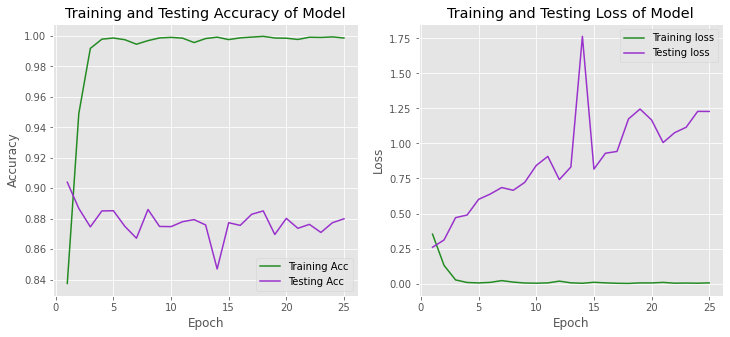

In [ ]:
# Code modified from https://realpython.com/python-keras-text-classification/

plt.style.use('ggplot')

# Function to print plot of accuracy and loss of training and test data
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'forestgreen', label='Training Acc')
    plt.plot(x, val_acc, 'darkorchid', label='Testing Acc')
    plt.title('Training and Testing Accuracy of Model')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch') 
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'forestgreen', label='Training loss')
    plt.plot(x, val_loss, 'darkorchid', label='Testing loss')
    plt.title('Training and Testing Loss of Model')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

# Plot model data
plot_history(history)